In [1]:
import matplotlib.pyplot as plt
import xarray as xr

%matplotlib inline 
plt.rcParams['figure.figsize'] = [16, 3]

from xarray.backends import BackendEntrypoint, BackendArray
from xarray.backends.common import BACKEND_ENTRYPOINTS
from xarray.core import indexing

import sys
sys.path.append('/Users/kai/src/psc/python')
import psc

class PscAdios2BackendEntrypoint(BackendEntrypoint):
    def open_dataset(
        self,
        filename_or_obj,
        *,
        drop_variables=None,
    ):
        print("open")
        return psc_open_dataset(filename_or_obj, drop_variables=drop_variables)

    open_dataset_parameters = ["filename_or_obj", "drop_variables"]

    def guess_can_open(self, filename_or_obj):
        print("guess", filename_or_obj)
        try:
            _, ext = os.path.splitext(filename_or_obj)
        except TypeError:
            return False
        return ext in {".bp"}
    
BACKEND_ENTRYPOINTS["pscadios2"] = PscAdios2BackendEntrypoint

class PscAdios2Array(BackendArray):
    def __init__(self, var, m):
        self._var = var
        self._m = m
        self.shape = var.shape[:-1]
        self.dtype = var.dtype
        
    def __getitem__(self, key):
        return indexing.explicit_indexing_adapter(
            key, self.shape, indexing.IndexingSupport.BASIC, self._getitem)
    
    def _getitem(self, args):
        return self._var[(*args, self._m)]

def psc_open_dataset(filename, length=None, drop_variables=None):
    file = psc.File(filename, length)
    fields = file.fields
    vars = {}
    for f in fields:
        field = file._fields[f]
        var = file._file[field.varname]
        coords = { "x": file.psc.x,
                   "y": file.psc.y,
                   "z": file.psc.z }
        arr = PscAdios2Array(var, field.component)
        vars[f] = xr.DataArray(arr, dims=['x', 'y', 'z'], coords=coords)

    return xr.Dataset(vars)

In [2]:
#xr.backends.plugins.guess_engine("/Users/kai/src/psc/build-mac/pfd.000000000.bp")
ds = xr.open_dataset("/Users/kai/src/psc/build-mac/pfd.000000100.bp", engine='pscadios2')
#ds

open


In [3]:
ds.jx_ec

reading  jeh [0 0 0 0] [  1  80 240   1]


<xarray.DataArray 'jx_ec' (x: 1, y: 80, z: 240)>
array([[[ 0.000000e+00,  0.000000e+00, ...,  3.687026e-05,  0.000000e+00],
        [-6.340064e-05, -4.785468e-05, ...,  0.000000e+00,  0.000000e+00],
        ...,
        [-8.375298e-06,  1.769851e-05, ..., -3.664266e-05, -1.696242e-05],
        [-3.613592e-05, -1.329397e-06, ..., -6.504738e-05, -5.926569e-05]]],
      dtype=float32)
Coordinates:
  * x        (x) float64 0.0
  * y        (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 75.0 76.0 77.0 78.0 79.0
  * z        (z) float64 0.0 1.0 2.0 3.0 4.0 ... 235.0 236.0 237.0 238.0 239.0

reading  jeh [  0   0 100   1] [ 1 80 51  1]


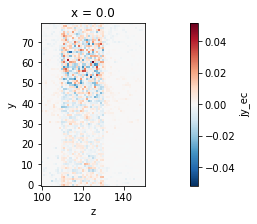

In [4]:
ds.jy_ec.sel(z=slice(100, 150)).plot()
plt.gca().set_aspect('equal')

In [5]:
ds = xr.open_dataset("/Users/kai/src/psc/build-mac/pfd_moments.000000100.bp", engine='pscadios2')

open


In [6]:
uy_e = ds.py_e[:,:,10:20]

reading  all_1st [ 0  0 10 18] [ 1 80 10  1]


In [7]:
print(type(ds.rho_e))
n_e = -ds.rho_e
print(type(n_e), type(ds.rho_e))

<class 'xarray.core.dataarray.DataArray'>
reading  all_1st [ 0  0  0 13] [  1  80 240   1]
<class 'xarray.core.dataarray.DataArray'> <class 'xarray.core.dataarray.DataArray'>


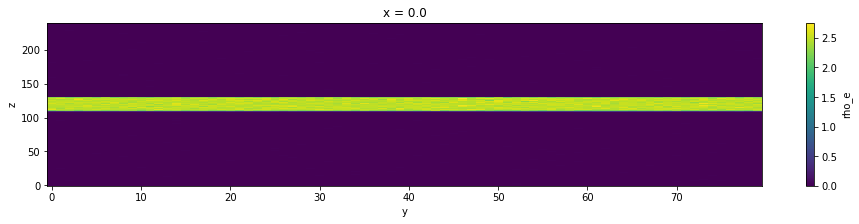

In [8]:
n_e.T.plot();

In [9]:
#ds.to_netcdf("ds.nc", engine='h5netcdf', format='netcdf4')

In [10]:
import expectexception
import numpy as np
import xarray as xr

In [11]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61597,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:61611,Total threads: 4
Dashboard: http://127.0.0.1:61613/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:61605,


In [12]:
import dask.array

dask.array.ones(
    (1000, 4), chunks=(2, 1)
).compute()  # should see activity in dashboard

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [13]:
ds = xr.open_dataset("/Users/kai/src/psc/build-mac/pfd_moments.000000000.bp", chunks='auto', engine='pscadios2')

open


In [14]:
ds

<xarray.Dataset>
Dimensions:   (x: 1, y: 80, z: 240)
Coordinates:
  * x         (x) float64 0.0
  * y         (y) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 75.0 76.0 77.0 78.0 79.0
  * z         (z) float64 0.0 1.0 2.0 3.0 4.0 ... 235.0 236.0 237.0 238.0 239.0
Data variables: (12/39)
    rho_he_e  (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    jx_he_e   (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    jy_he_e   (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    jz_he_e   (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    px_he_e   (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    py_he_e   (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    ...        ...
    txx_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    tyy_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    tzz_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    txy_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    tyz_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>
    tzx_i     (x, y, z) float32 dask.array<chunksize=(1, 80, 240), meta=np.ndarray>

In [16]:
n_e = -ds.rho_e

In [17]:
n_e.plot()

distributed.protocol.core - CRITICAL - Failed to Serialize
Traceback (most recent call last):
  File "/Users/kai/Library/Python/3.7/lib/python/site-packages/distributed/protocol/core.py", line 70, in dumps
    frames[0] = msgpack.dumps(msg, default=_encode_default, use_bin_type=True)
  File "/Users/kai/Library/Python/3.7/lib/python/site-packages/msgpack/__init__.py", line 35, in packb
    return Packer(**kwargs).pack(o)
  File "msgpack/_packer.pyx", line 292, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 298, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 295, in msgpack._cmsgpack.Packer.pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 264, in msgpack._cmsgpack.Packer._pack
  File "msgpack/_packer.pyx", line 231, in msgpack._cmsgpack.

CancelledError: 

In [ ]:
`